In [1]:
import pandas as pd
import netCDF4 as netcdf
import xarray as xr
from ipyleaflet import Map, basemaps, AntPath, Marker, Polyline
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle, xroms
import cartopy.crs as ccrs
import xesmf as xe
import pandas as pd
from scipy import interpolate
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geopy.distance import geodesic

# Define reverse colormap function

def reverse_colourmap(cmap, name = 'my_cmap_r'):   
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

In [6]:
count = 0
url = '/mnt/d/NOPP/IAN_FORECAST/Ian2022_forcing_regular.nc'
ds_mod = xr.open_dataset(url)
time_ini_model = ds_mod.pair_time.values[0]
time_end_model = ds_mod.pair_time.values[-1]
time = ds_mod.pair_time.values
nt = time.size
nf = 1 
if count == 0:
    lon_mint = [[0 for x in range(nt)] for y in range(nf)]
    lon_mint = np.asarray(lon_mint,dtype='f')
    lat_mint = [[0 for x in range(nt)] for y in range(nf)]
    lat_mint = np.asarray(lat_mint,dtype='f')
    Pair_mint = [[0 for x in range(nt)] for y in range(nf)]
    Pair_mint = np.asarray(Pair_mint, dtype='f')
    Wind_maxt =  [[0 for x in range(nt)] for y in range(nf)]  
    Wind_maxt = np.asarray(Wind_maxt,dtype='f')
 
Uwind = ds_mod.Uwind[:,0:-2,:].values
Vwind = ds_mod.Vwind[:,0:-2,:].values
Wind = (Uwind**2+Vwind**2)**0.5
del Uwind,Vwind
Pair = ds_mod.Pair[:,0:-2,:].values
lon_rho = ds_mod.lon[0:-2,:].values
lat_rho = ds_mod.lat[0:-2,:].values

# Determine the minimum pressure path (track of the TC) 
nt = len(ds_mod.pair_time.values)
lon_min = np.zeros([nt])
lat_min = np.zeros([nt])
Pair_min = np.zeros([nt])
Wind_max = np.zeros([nt])
 
for tt in range(len(ds_mod.pair_time.values)):  
   Pairc = Pair[tt,:,:]
   Windc = Wind[tt,:,:]
   minloc = np.where(Pairc == np.nanmin(Pairc))
   lon_min[tt] = (lon_rho[minloc[0][0], minloc[1][0]])
   lat_min[tt] = (lat_rho[minloc[0][0], minloc[1][0]])
   Pair_min[tt] = np.nanmin(Pairc)
   Wind_max[tt] = np.nanmax(Windc)
 
lon_mint[count,:] = lon_min
lat_mint[count,:] = lat_min
Pair_mint[count,:] = Pair_min
Wind_maxt[count,:] = Wind_max

1) Load Ian (2022) b-deck file and plot track, minimum pressure along track and maximum sustained wind speed

In [8]:
# Load TC best track and plot TC best track and minimum pressure

path_out = '/mnt/d/NOPP/IAN_ANALYSIS/'

df = pd.read_excel('/mnt/d/NOPP/IAN_MEASUREMENTS/b_deck/bal092022.xlsx')
track_lat = df.lat[30:44].to_numpy()
track_lon = df.lon[30:44].to_numpy()
track_Pair = df.pair[30:44].to_numpy()
track_Vmax = df.Vmax[30:44].to_numpy()
track_ian = np.transpose([track_lat,track_lon]).tolist()
#time_ian = np.arange(datetime(2022,9,19,12,0,0), datetime(2022,10,2,6,0,0), timedelta(hours=6)).astype(datetime)
time_ian = np.arange(datetime(2022,9,27,0,0,0), datetime(2022,9,30,12,0,0), timedelta(hours=6)).astype(datetime)

In [27]:
# Take model results at the same instants as measurments

time_mod_int = np.arange(datetime(2022,9,23,6,0,0), datetime(2022,10,6,0,0,0), timedelta(hours=1)).astype(datetime)

Pair_min_mod_int = Pair_min[np.where(np.isin(time_mod_int, time_ian))]
Wind_max_mod_int =  Wind_max[np.where(np.isin(time_mod_int, time_ian))]
lon_min_mod_int = lon_min[np.where(np.isin(time_mod_int, time_ian))]
lat_min_mod_int = lat_min[np.where(np.isin(time_mod_int, time_ian))]

diff_pair = Pair_min_mod_int - track_Pair
diff_wind_max = Wind_max_mod_int - track_Vmax*0.514444

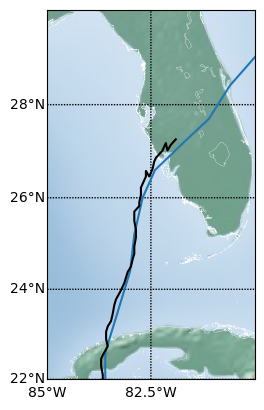

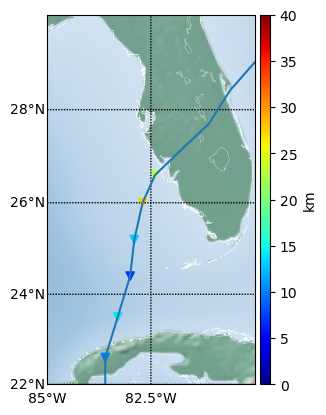

In [18]:
# Map best track

cmap = mpl.cm.jet
cmap_r = reverse_colourmap(cmap)
fig = plt.figure()
map = Basemap(llcrnrlon=-85.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=30.,
             resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,30.,2.0)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-85.0,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x, y = map(track_lon,track_lat)  # transform coordinates
x_mod, y_mod = map(lon_min,lat_min)  # transform coordinates
x_mod_int, y_mod_int = map(lon_min_mod_int,lat_min_mod_int)
plt.plot(x, y)
plt.plot(x_mod[80:140], y_mod[80:140], color='0')
#plt.plot(x_mod_int, y_mod_int, color='0.5')
fig_name = path_out + 'Ian_track_best_available_coawst.png'
plt.savefig(fig_name)
plt.show()

diff_track = ((x-x_mod_int)**2+(y-y_mod_int)**2)**0.5

fig = plt.figure()
map = Basemap(llcrnrlon=-85.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=30.,
             resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,30.,2.0)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-85.0,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x, y = map(track_lon,track_lat)  # transform coordinates
plt.plot(x, y)
plt.scatter(x[1:8], y[1:8], c = diff_track[1:8]/1000, marker='v', cmap=cmap) ## Important
plt.clim(0,40)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="km")
plt.clim(0,40)
fig_name = path_out + 'Ian_track_best_available_diff_coawst.png'
plt.savefig(fig_name)
plt.show()

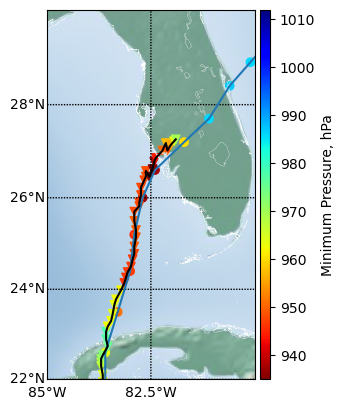

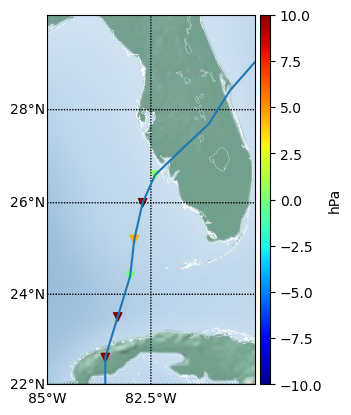

In [24]:
# Map minimum atmospheric pressure along best track

cmap = mpl.cm.jet
cmap_r = reverse_colourmap(cmap)
fig = plt.figure()
map = Basemap(llcrnrlon=-85.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=30.,
             resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,30.,2.0)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-85.0,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x, y = map(track_lon,track_lat)  # transform coordinates
x_mod, y_mod = map(lon_min,lat_min)  # transform coordinates

plt.plot(x, y)
plt.scatter(x, y, c = track_Pair, marker='o', cmap=cmap_r) ## Important
plt.clim(935,1012)
plt.plot(x_mod[80:140], y_mod[80:140], color='0')
plt.scatter(x_mod[80:140], y_mod[80:140], c = Pair_min[80:140], marker='v', cmap=cmap_r) ## Important
plt.clim(935,1012)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="Minimum Pressure, hPa")
plt.clim(935,1012)
fig_name = path_out + 'Ian_track_minp_best_available_coawst.png'
plt.savefig(fig_name)
plt.show()

fig = plt.figure()
map = Basemap(llcrnrlon=-85.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=30.,
             resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,30.,2.0)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-85.0,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x, y = map(track_lon,track_lat)  # transform coordinates
plt.plot(x, y)
plt.scatter(x[1:8], y[1:8], c = diff_pair[1:8], marker='v', cmap=cmap) ## Important
plt.clim(-10,10)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="hPa")
plt.clim(-10,10)
fig_name = path_out + 'Ian_pmin_diff_coawst.png'
plt.savefig(fig_name)
plt.show()

In [28]:
diff_wind_max

array([ -7.50749082,  -1.55975263, -16.09480588,  -7.32825025,
         4.42865435,  -1.39021283,  -9.9171336 , -11.61824063,
       -13.76025312,  -4.53753653,  -5.79111853,   1.2602672 ,
        -0.3243582 ,  -5.84139479])

In [25]:
diff_pair

array([10.67919922,  7.80371094, 10.1854248 , 12.68231201, -0.15557861,
        4.51452637, 10.73919678,  0.34594727,  3.27545166, -3.54345703,
        4.65136719,  1.82733154, -4.39581299, -6.34130859])

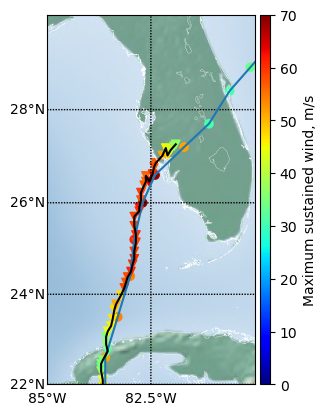

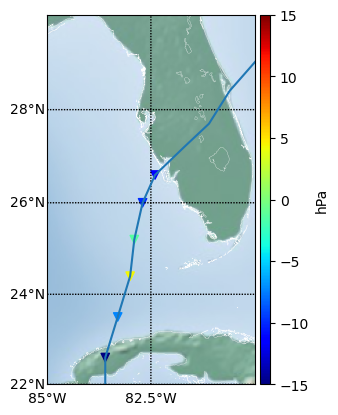

In [29]:
# Map maximum wind velocity along best track

cmap = mpl.cm.jet
cmap_r = reverse_colourmap(cmap)
fig = plt.figure()
map = Basemap(llcrnrlon=-85.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=30.,
             resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,30.,2.0)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-85.0,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x, y = map(track_lon,track_lat)  # transform coordinates
x_mod, y_mod = map(lon_min,lat_min)  # transform coordinates

plt.plot(x[0:39], y[0:39])
plt.scatter(x[0:39], y[0:39], c = track_Vmax[0:39]*0.514444, marker='o', cmap=cmap) ## Important
plt.clim(0,70)
plt.plot(x_mod[80:140], y_mod[80:140], color='0')
plt.scatter(x_mod[80:140], y_mod[80:140], c = Wind_max[80:140], marker='v', cmap=cmap) ## Important
plt.clim(0,70)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="Maximum sustained wind, m/s")
plt.clim(0,70)
fig_name = path_out + 'Ian_track_maxV_best_available_coawst.png'
plt.savefig(fig_name)
plt.show()

fig = plt.figure()
map = Basemap(llcrnrlon=-85.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=30.,
             resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,30.,2.0)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-85.0,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x, y = map(track_lon,track_lat)  # transform coordinates
plt.plot(x, y)
plt.scatter(x[1:8], y[1:8], c = diff_wind_max[1:8], marker='v', cmap=cmap) ## Important
plt.clim(-15,15)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="hPa")
plt.clim(-15,15)
fig_name = path_out + 'Ian_windmax_diff_coawst.png'
plt.savefig(fig_name)
plt.show()

2. Load COAWST forecast results

In [30]:
# Load COAWST simulation results

roms_file_1 = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Ian2022/ian4/qck/ian_ocean_sabgom_qck.nc'
run_name_1 = 'IAN_BEST_AVAILABLE'
chunks={'ocean_time':121,'xi_rho':690,'eta_rho':545}
ds_mod_1 = xroms.open_netcdf(roms_file_1,chunks=chunks) 

time_ini_model_1 = ds_mod_1.ocean_time.values[0]
time_end_model_1 = ds_mod_1.ocean_time.values[-1]
t_ini_1 = str(np.datetime_as_string(time_ini_model_1))
t_end_1 = str(np.datetime_as_string(time_end_model_1))
lon_rho_1 = ds_mod_1.lon_rho.values
lat_rho_1 = ds_mod_1.lat_rho.values

4. NDBC buoy analysis

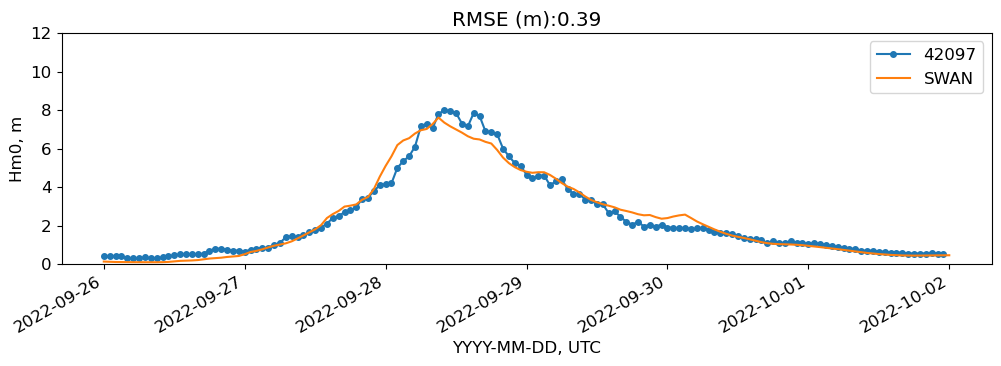

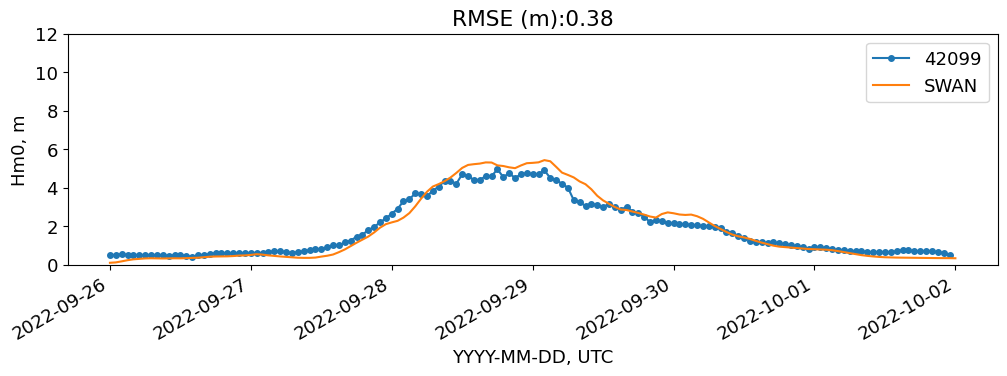

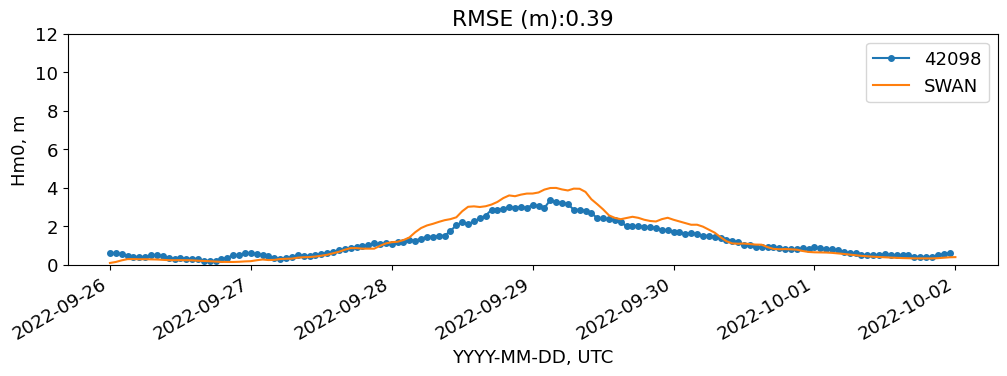

In [35]:
##### Load, plot and analyze NDBC buoy observations

buoys = "42097","42099","42098"

lat_ndbc_1 = []
lon_ndbc_1 = []
rmse_whgt_ndbc_1 = []
max_error_whgt_ndbc_1 = []

for buoy in buoys:
    
 # Open dataset
 url ='https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/' + str(buoy) + '/' + str(buoy) + 'h9999.nc'
 ds = xr.open_dataset(url).sel(time=slice(time_ini_model_1,time_end_model_1)).resample(time="H").mean()
 lat1 = ds.latitude.values
 lon1 = ds.longitude.values

 HWavel_1 = ds_mod_1.Hwave.xroms.sel2d(lon1, lat1)
 HWavel_mod1 = ds_mod_1.Hwave.xroms.sel2d(lon1, lat1).sel(ocean_time=slice(time_ini_model_1,time_end_model_1)).values 
 Hm0_mes = ds.wave_height.sel(time=slice(time_ini_model_1,time_end_model_1)).values

     
 try:
   # Calculate Root Mean Square Error and max error
   differences = HWavel_mod1[0:-1] - np.squeeze(Hm0_mes[:,0,0])
   differences_squared = differences ** 2 
   mean_of_differences_squared = np.nanmean(differences_squared,axis=0)
   rmse_1 = np.sqrt(mean_of_differences_squared)
   error_max_1 = np.nanmax(np.absolute( HWavel_mod1 - Hm0_mes))
 except:
   rmse_1 = np.nan
   error_max_1 = np.nan
    
 rmse_whgt_ndbc_1.append(rmse_1)
 max_error_whgt_ndbc_1.append(error_max_1)
 lat_ndbc_1.append(lat1)
 lon_ndbc_1.append(lon1)
 rmse_str_1 = str(rmse_1)[0:4]   
 max_err_1 = str(error_max_1)[0:4] 
 
 fig, ax = plt.subplots(figsize=(12, 3))
 ds.wave_height.plot(marker='o',markersize=4)
 HWavel_1.plot()
 ax.set(xlabel="YYYY-MM-DD, UTC",
       ylabel="Hm0, m",
       title= 'RMSE (m):' + rmse_str_1 )
 ax.set_ylim([0, 12])
 plt.legend([buoy,'SWAN'])  
 plt.rcParams.update({'font.size': 13})
 fig_name = path_out +  buoy + '_ndbc_.png'
 plt.savefig(fig_name) 

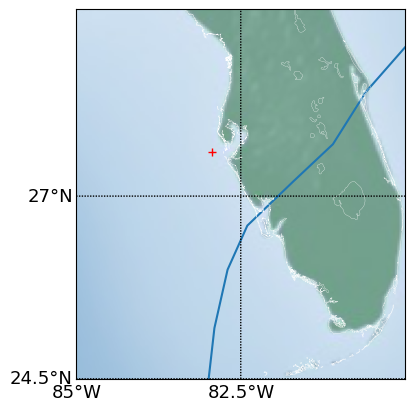

In [36]:
fig = plt.figure()
map = Basemap(llcrnrlon=-85.0,llcrnrlat=24.5,urcrnrlon=-80.,urcrnrlat=29.5,
            resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
x, y = map(track_lon,track_lat)  # transform coordinates
plt.plot(x, y)
x4, y4 = map(lon1,lat1)  # transform coordinates
plt.plot(x4, y4,color='red',marker='+')
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(24.5,29.5,2.5)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-90,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
plt.rcParams.update({'font.size': 12})
fig_name = path_out + 'ndbc_loc.png'
plt.savefig(fig_name)
plt.show()

# Delete varaibles
#del HWavel_1,HWavel_mod1,ds,lon1,lat1 
#del differences, differences_squared, mean_of_differences_squared

/home/molabarrieta/anaconda3/envs/XROMS/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


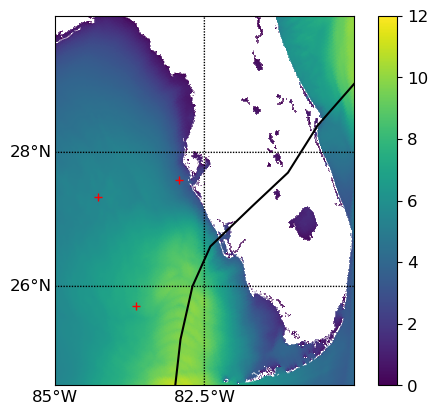

In [43]:
fig = plt.figure()
map = Basemap(llcrnrlon=-85.0,llcrnrlat=24.5,urcrnrlon=-80.,urcrnrlat=30.,
             resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
x, y = map(track_lon,track_lat)  # transform coordinates
x4, y4 = map(lon_rho_1,lat_rho_1)
x5, y5 = map(lon_ndbc_1[0], lat_ndbc_1[0])  # transform coordinates
x6, y6 = map(lon_ndbc_1[1], lat_ndbc_1[1])  # transform coordinates
x7, y7 = map(lon_ndbc_1[2], lat_ndbc_1[2])  # transform coordinates
plt.plot(x5, y5,color='red',marker='+')
plt.plot(x6, y6,color='red',marker='+')
plt.plot(x7, y7,color='red',marker='+')
#map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22,30.,2.0)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-85,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
plt.plot(x, y,color = 'black')
ax1 = plt.gca()
cf = ax1.pcolormesh(x4, y4, ds_mod_1.Hwave.max(dim=["ocean_time"]), vmin = 0, vmax = 12)
fig.colorbar(cf, ax=ax1)
cf.set_clim(0,12)
plt.rcParams.update({'font.size': 12})
fig_name = path_out + 'Hm0max_ndbc_loc.png'
plt.savefig(fig_name)
plt.show()

5. SIO buoy analysis

In [45]:
# Load SIO wave buoy data

ds0 = xr.open_dataset(r'/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/ONR_NOPP2022_6609_06ce_8613.nc')
ds01 = ds0.where(ds0.time >= time_ini_model_1)
ds02 = ds01.where(ds01.time <= time_end_model_1)
ds02['row'] = ds02.time.values
ds = ds02.sel(row = ds02.row.notnull())
del ds02, ds01, ds0

ds0 = xr.open_dataset(r'/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/ONR_NOPP2022_6609_06ce_8613.nc')
ds01 = ds0.where(ds0.time >= time_ini_model_1)
ds02 = ds01.where(ds01.time <= time_end_model_1)
ds02['row'] = ds02.time.values
ds_sio = ds02.sel(row = ds02.row.notnull())
del ds02, ds01, ds0

0.37


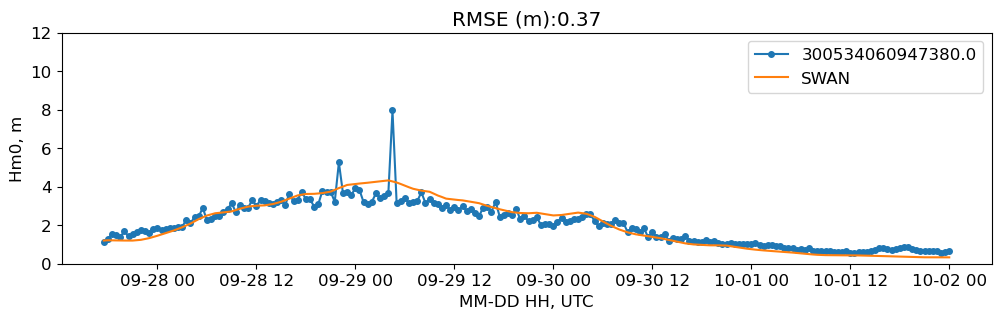

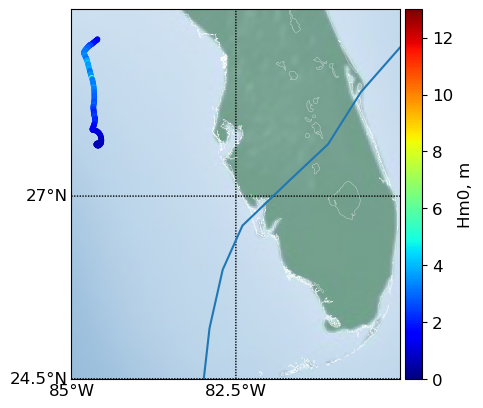

0.38


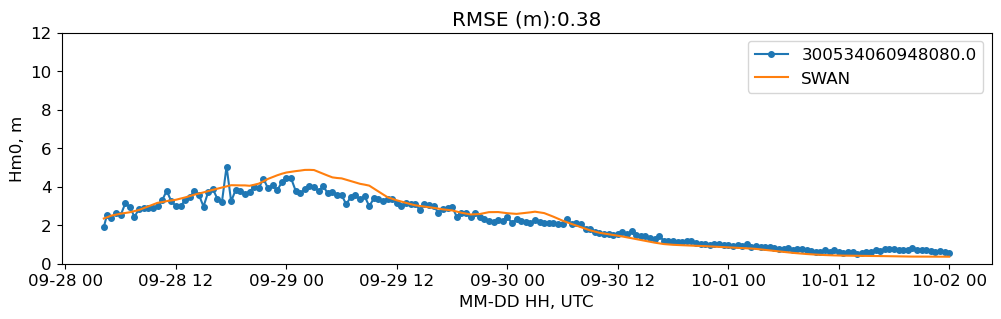

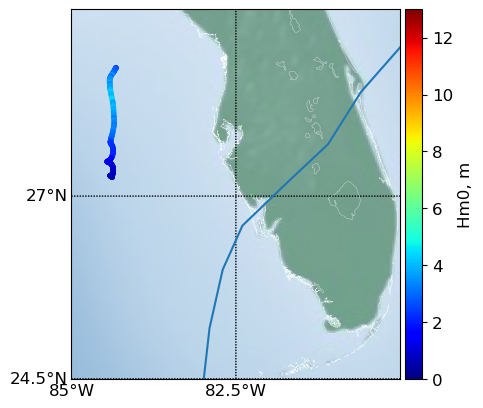

0.37


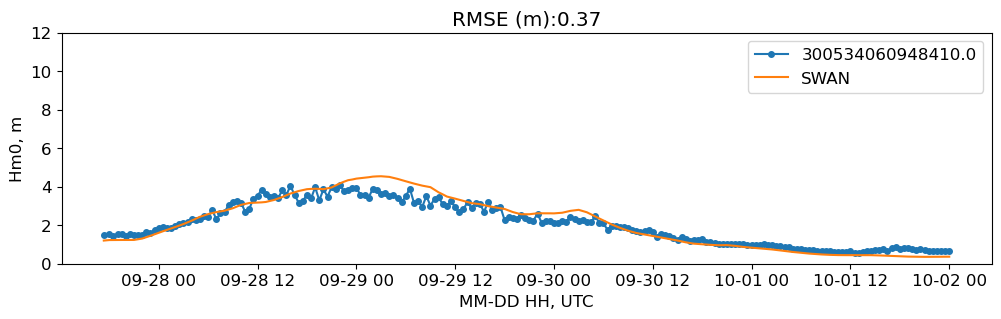

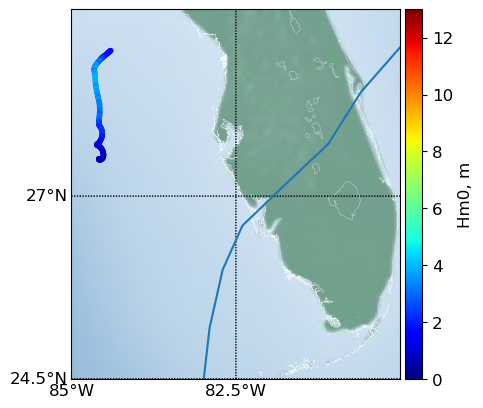

0.39


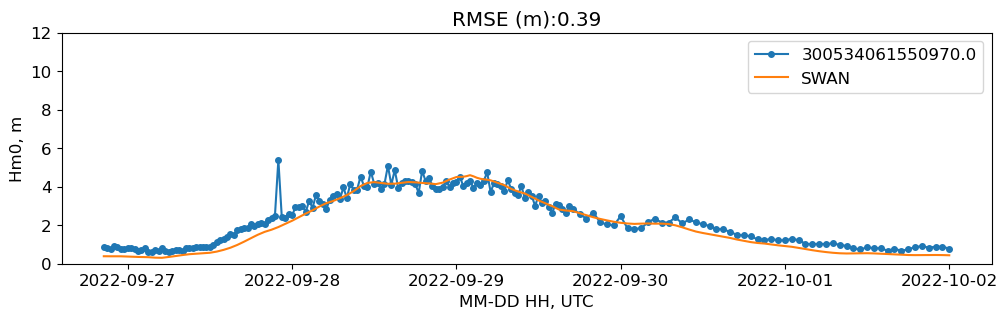

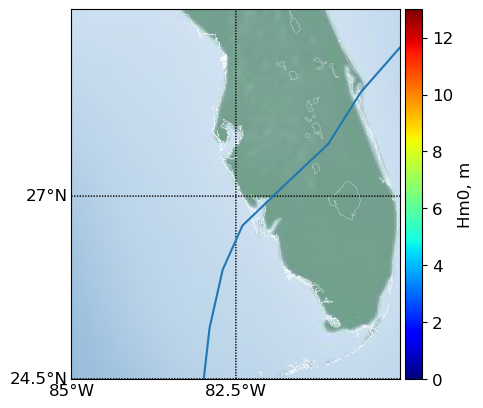

0.54


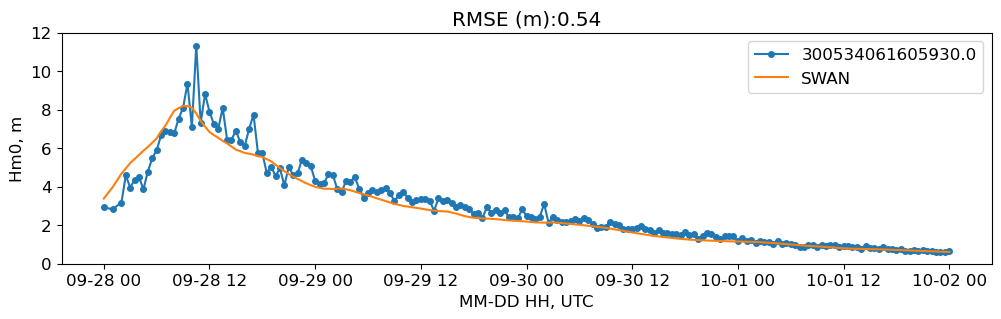

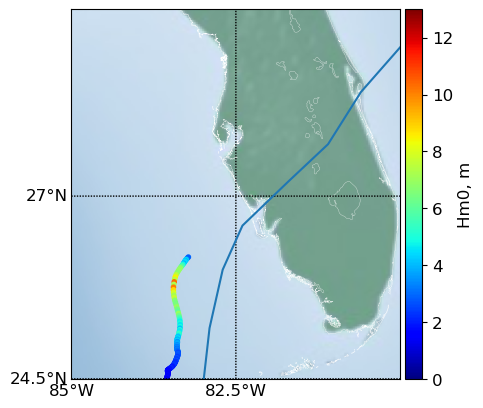

0.40


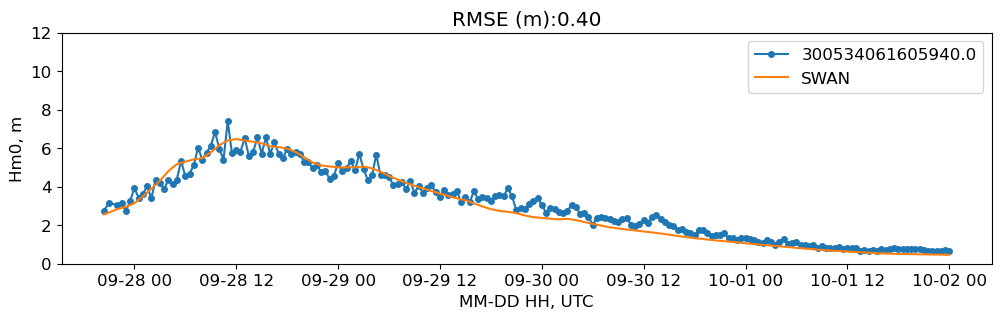

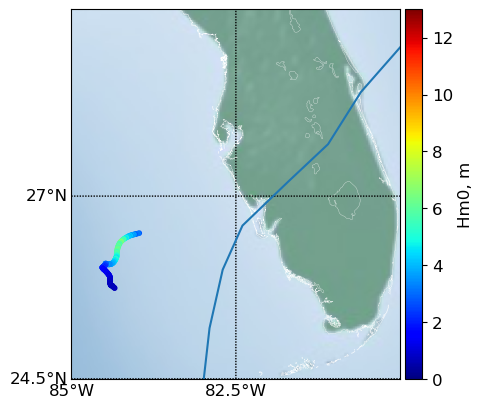

0.67


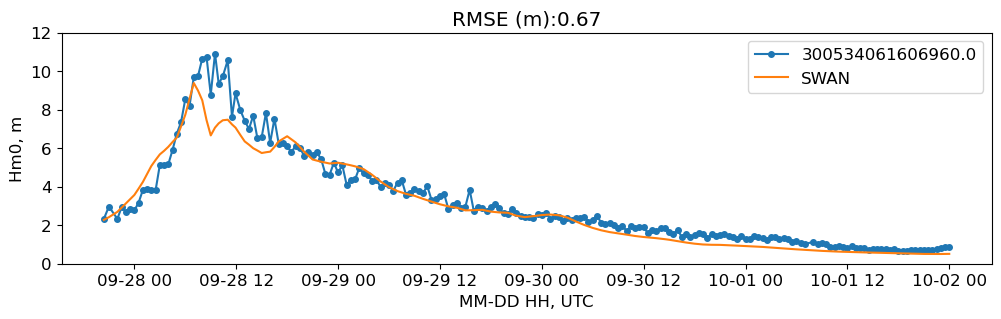

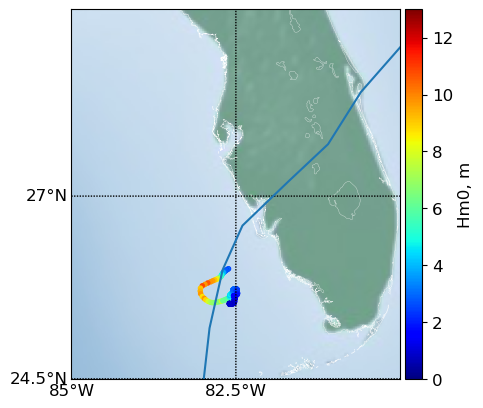

0.52


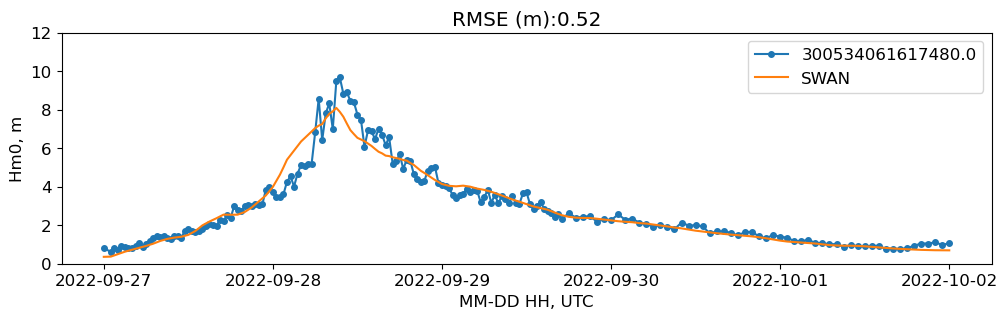

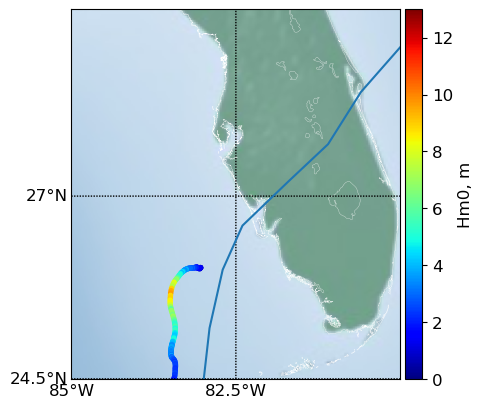

0.37


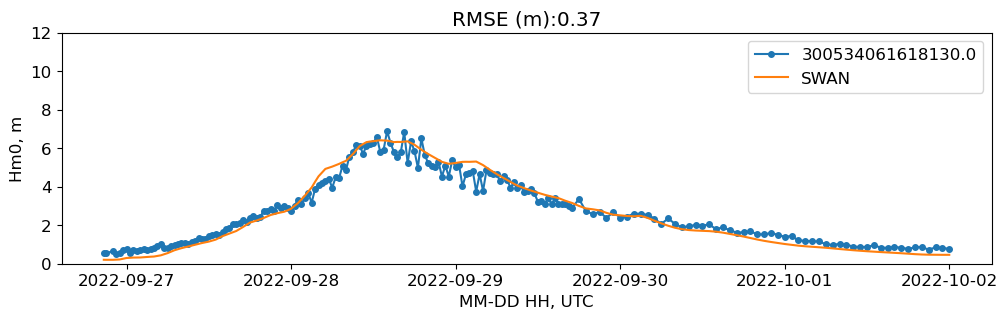

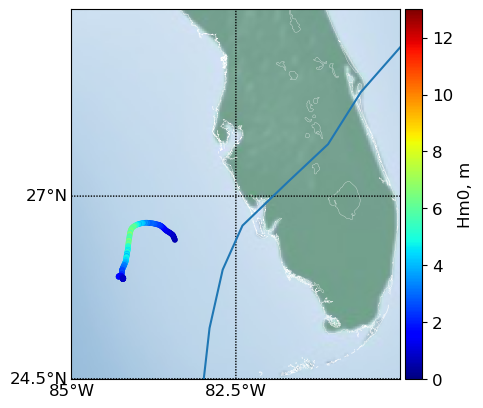

0.35


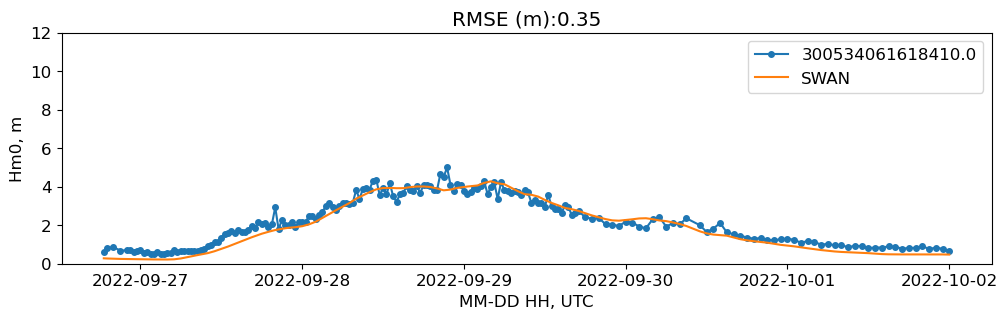

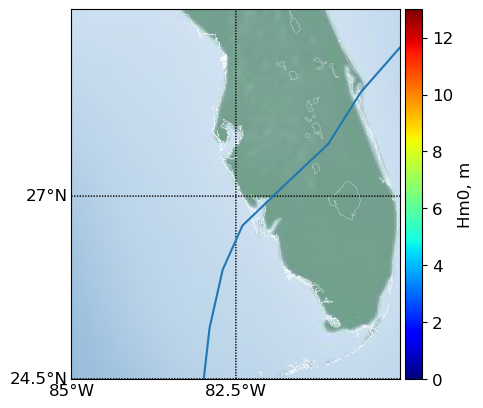

In [46]:
# Compare COAWST results and SIO results 

x_id = np.array(ds.platform_id.values)
buoy_id = np.unique(x_id)

rmse_wvht_sio_1 = []
error_max_wvht_sio_1 = []
lon_mean_sio_1 = []
lat_mean_sio_1 = []

rmse_wvht_sio_2 = []
error_max_wvht_sio_2 = []
lon_mean_sio_2 = []
lat_mean_sio_2 = []

rmse_wvht_sio_3 = []
error_max_wvht_sio_3 = []
lon_mean_sio_3 = []
lat_mean_sio_3 = []

for buoy in buoy_id[-11:-1]:
    
    ds1 = ds.where(ds.platform_id==buoy, drop=True)
    lat = np.array(ds1.latitude.values)
    lon = np.array(ds1.longitude.values)
    wvht = np.array(ds1.wvht.values)
    
    N=len(lon)
    dstmp=ds_mod_1.Hwave.to_dataset()
    varout = xr.Dataset({"lat": (["locations"], lat), "lon": (["locations"], lon)})
    dstmp = dstmp.rename({'lon_rho': "lon", 'lat_rho': "lat"})
    regridder = xe.Regridder(dstmp, varout, "bilinear", locstream_out=True)
    tmp1 = regridder(dstmp, keep_attrs=True)
    tmp2= tmp1.interp(ocean_time=ds1.time)
    Hwave_SWAN_1=tmp2.isel(row=xr.DataArray(np.arange(0,N)),locations=xr.DataArray(np.arange(0,N)))
    
    wvht_ac = np.absolute(ds1.wvht[0:-2].values-ds1.wvht[1:-1].values)    
    spike = np.argwhere(wvht_ac > 1.0)
    wvht2 = wvht
    wvht2 [spike] = (wvht2 [spike-1] + wvht2 [spike+1])/2
    
    try:
       # Calculate Root Mean Square Error and max error
       differences = Hwave_SWAN_1.Hwave.values- wvht2
       differences_squared = differences ** 2 
       mean_of_differences_squared = np.nanmean(differences_squared, axis=0)
       rmse_1 = np.sqrt(mean_of_differences_squared)
       error_max_1 = np.nanmax(np.absolute(Hwave_SWAN_1.Hwave.values- wvht2))
    except:
       rmse_1 = np.nan
       error_max_1 = np.nan
        
    rmse_wvht_sio_1.append(rmse_1)
    error_max_wvht_sio_1.append(error_max_1)
    lon_mean_sio_1.append(np.mean(lon))
    lat_mean_sio_1.append(np.mean(lat))
      
    plot_comp_sio=1
    if ((plot_comp_sio==1)): 
     # Plot results
     rmse_str_1 = str(rmse_1)[0:4]   
     max_err_1 = str(error_max_1)[0:4]
     print(rmse_str_1)
     fig, ax = plt.subplots(figsize=(12, 3))
     ax.plot(ds1.time,ds1.wvht, marker='o',markersize=4)
     plt.plot(Hwave_SWAN_1.ocean_time,Hwave_SWAN_1.Hwave)
     plt.title('RMSE (m):' + rmse_str_1)
     plt.ylabel('Hm0, m')
     plt.xlabel('MM-DD HH, UTC')
     ax.set_ylim([0, 12])
     plt.legend([buoy,'SWAN']) 
     fig_name = path_out + str(int(buoy)) + '_sio.png'
     plt.savefig(fig_name) 
        
     # Plot TC track, locations of NDBC buoys, SIO buoys, MicroSwifts and Spotters 

     x4, y4 = map(lon,lat)
     wvht_sio = wvht
     fig = plt.figure()
     map = Basemap(llcrnrlon=-85.0,llcrnrlat=24.5,urcrnrlon=-80.,urcrnrlat=29.5,
             resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
     map.shadedrelief()
     map.drawcoastlines(color='white', linewidth=0.2)
     parallels = np.arange(24.5,29.5,2.5)
     # labels = [left,right,top,bottom]
     map.drawparallels(parallels,labels=[True,False,False,False])
     meridians = np.arange(-85,-80,2.5)
     map.drawmeridians(meridians,labels=[False,False,False,True])
     x, y = map(track_lon,track_lat)  # transform coordinates
     plt.plot(x, y)
     plt.scatter(x4, y4, c= wvht_sio, marker='.', cmap='jet')
     plt.clim(0,13)
     ax = plt.gca()
     divider = make_axes_locatable(ax)
     cax = divider.append_axes("right", size="5%", pad=0.05) 
     plt.colorbar(cax=cax, label="Hm0, m")
     plt.clim(0,13)
     plt.rcParams.update({'font.size': 12})
     fig_name = path_out + str(int(buoy)) + '_sio_Hm0.png'
     plt.savefig(fig_name)
     plt.show()

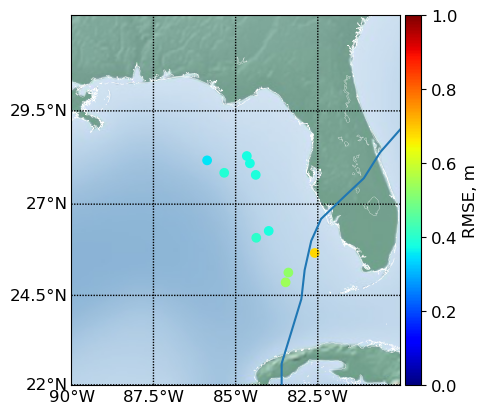

In [49]:
# Plot TC track and SIO buoy measurements


fig = plt.figure()
map = Basemap(llcrnrlon=-90.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=32.,
      resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,32.,2.5)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-90,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x_sio, y_sio = map(lon_mean_sio_1,lat_mean_sio_1)
x, y = map(track_lon,track_lat)  # transform coordinates
plt.plot(x, y)
plt.scatter(x_sio, y_sio, c= rmse_wvht_sio_1, marker='o', cmap='jet')
plt.clim(0,13)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="RMSE, m")
plt.clim(0,1)
plt.rcParams.update({'font.size': 12})
fig_name = path_out + str(int(buoy)) + 'rmse_sio_Hm0.png'
plt.savefig(fig_name)
plt.show()

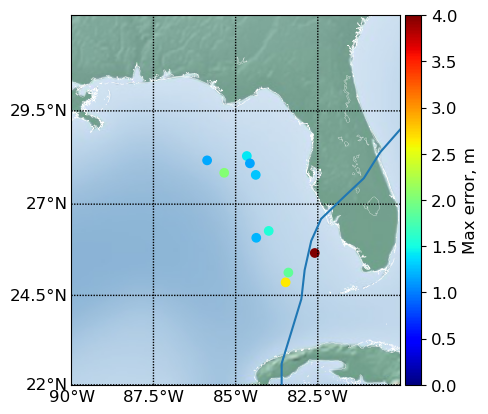

In [50]:
# Plot TC track and SIO buoys

fig = plt.figure()
map = Basemap(llcrnrlon=-90.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=32.,
      resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,32.,2.5)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-90,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x_sio, y_sio = map(lon_mean_sio_1,lat_mean_sio_1)
x, y = map(track_lon,track_lat)  # transform coordinates
plt.plot(x, y)
plt.scatter(x_sio, y_sio, c= error_max_wvht_sio_1, marker='o', cmap='jet')
plt.clim(0,13)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="Max error, m")
plt.clim(0,4)
plt.rcParams.update({'font.size': 12})
fig_name = path_out + str(int(buoy)) + 'max_error_sio_Hm0.png'
plt.savefig(fig_name)
plt.show()

6. MicroSwift buoy analysis

0.46415777334833247 1.292897218123878


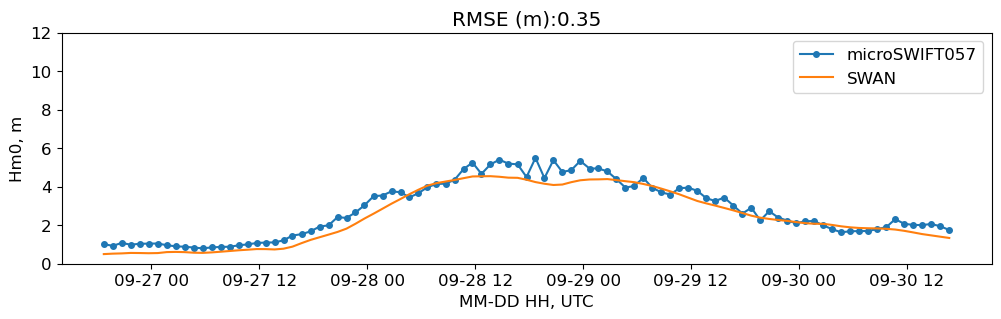

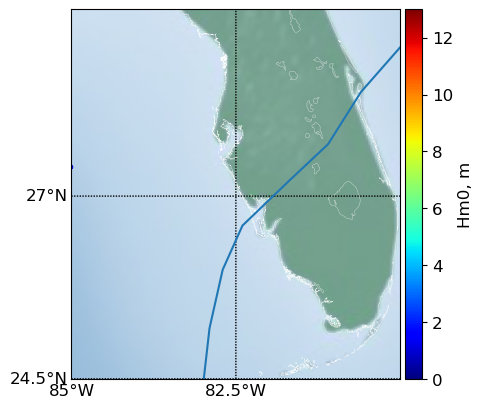

0.6097574949203127 1.743313331927454


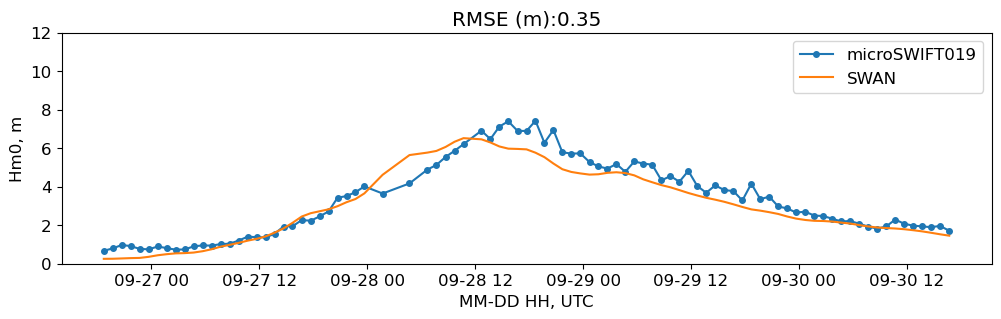

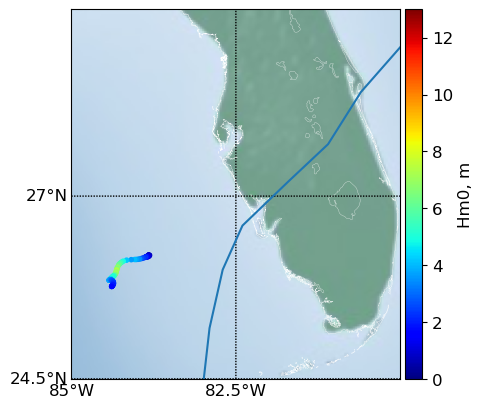

In [54]:
# Read microSWIFT data and plot bulk- wave parameters

microswift_file = '/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/microSWIFTs/microSWIFT057.nc'
ds_57 = xr.open_dataset(microswift_file)
lon_57 = ds_57.lon_lagrangian.values
lat_57 = ds_57.lat_lagrangian.values
whgt_57 = ds_57.sigwaveheight.values

microswift_file = '/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/microSWIFTs/microSWIFT019.nc'
ds_19 = xr.open_dataset(microswift_file)
lon_19 = ds_19.lon_lagrangian.values
lat_19 = ds_19.lat_lagrangian.values
whgt_19 = ds_19.sigwaveheight.values

rmse_wvht_ms_1 = []
error_max_wvht_ms_1 = []
lon_mean_ms_1 = []
lat_mean_ms_1 = []

# Read microSWIFT data and plot bulk- wave parameters

microswifts= 'microSWIFT057','microSWIFT019'
microswifts_path = '/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/microSWIFTs/'

for microswift in microswifts:
 microswift_file= microswifts_path + microswift + '.nc'
 ds = xr.open_dataset(microswift_file)
 lon_ms = ds.lon_lagrangian.values
 lat_ms = ds.lat_lagrangian.values
 Hm0_ms = ds.sigwaveheight.values
 time_ms = ds.time.values

 count = 0
 count1 = 0
 Hwave_SWAN_ms_1 = Hm0_ms*0
 lon_SWAN_ms_1 = Hm0_ms*0
 lat_SWAN_ms_1 = Hm0_ms*0
       
 for time in time_ms:
  if time_ms[count]<= time_end_model_1 and time_ms[count] >= time_ini_model_1:
   tt_1 = ds_mod_1.Hwave.interp(ocean_time = time_ms[count])  # intepolate in time   
   # Find closest ROMS nodes to station locations
   dist = np.sqrt((lon_rho_1-lon_ms[count])**2+(lat_rho_1-lat_ms[count])**2)
   indy, indx = np.where(dist == np.amin(dist))
   lon_SWAN_ms_1[count] = lon_rho_1[indy,indx]
   lat_SWAN_ms_1[count] = lat_rho_1[indy,indx]
   Hwave_SWAN_ms_1[count] = tt_1[indy,indx].values
  else:
   Hwave_SWAN_ms_1[count] = np.nan
   lon_SWAN_ms_1[count] = np.nan
   lat_SWAN_ms_1[count] = np.nan
  count =count + 1   

 try:
  # Calculate Root Mean Square Error and max error
  differences = Hwave_SWAN_ms_1- Hm0_ms
  differences_squared = differences ** 2 
  mean_of_differences_squared = np.nanmean(differences_squared,axis=0)
  rmse = np.sqrt(mean_of_differences_squared)
  error_max = np.nanmax(np.absolute(Hwave_SWAN_ms_1- Hm0_ms))
  print(rmse,error_max)
 except:
  rmse = np.nan
  error_max = np.nan
   
 rmse_wvht_ms_1.append(rmse_1)
 error_max_wvht_ms_1.append(error_max_1)
 lon_mean_ms_1.append(np.mean(lon_ms))
 lat_mean_ms_1.append(np.mean(lat_ms))
   
 rmse_str_1 = str(rmse_1)[0:4]   
 max_err_1 = str(error_max_1)[0:4]
       
 fig, ax = plt.subplots(figsize=(12, 3))
 ax.plot(time_ms,Hm0_ms,marker='o',markersize=4)
 ax.plot(time_ms,Hwave_SWAN_ms_1)
 ax.set_ylim([0, 12])
# plt.title(microswift + ' Hm0 RMSE (m):' + rmse_str + ' Max error (m):' + max_err)
 plt.title('RMSE (m):' + rmse_str_1 )
 plt.ylabel('Hm0, m')
 plt.xlabel('MM-DD HH, UTC')
 plt.legend([microswift,'SWAN'])
 fig_name = path_out + microswift +' _Hm0.png'
 plt.savefig(fig_name)
    
# Plot TC track and MicroSwifts 
 
 wvht_ms = Hm0_ms
 fig = plt.figure()
 map = Basemap(llcrnrlon=-85.0,llcrnrlat=24.5,urcrnrlon=-80.,urcrnrlat=29.5,
            resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
 map.shadedrelief()
 map.drawcoastlines(color='white', linewidth=0.2)
 parallels = np.arange(24.5,29.5,2.5)
 # labels = [left,right,top,bottom]
 map.drawparallels(parallels,labels=[True,False,False,False])
 meridians = np.arange(-85,-80,2.5)
 map.drawmeridians(meridians,labels=[False,False,False,True])
 x4, y4 = map(lon_ms,lat_ms)
 x, y = map(track_lon,track_lat)  # transform coordinates
 plt.plot(x, y)
 plt.scatter(x4, y4, c= wvht_ms, marker='.', cmap='jet')
 plt.clim(0,13)
 ax = plt.gca()
 divider = make_axes_locatable(ax)
 cax = divider.append_axes("right", size="5%", pad=0.05) 
 plt.colorbar(cax=cax, label="Hm0, m")
 plt.rcParams.update({'font.size': 12})
 fig_name = path_out + microswift + '_ms_Hm0.png'
 plt.savefig(fig_name)
 plt.show()

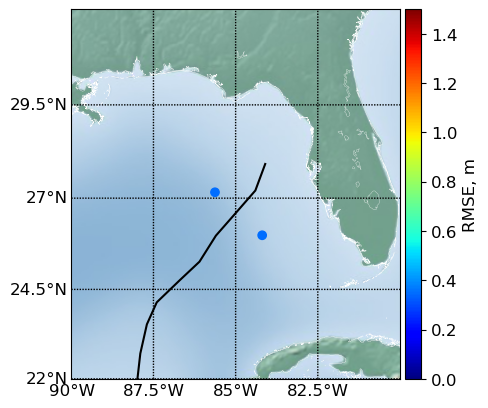

In [55]:
# Plot TC track, MicroSwift

fig = plt.figure()
map = Basemap(llcrnrlon=-90.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=32.,
      resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,32.,2.5)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-90,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x_ms, y_ms = map(lon_mean_ms_1,lat_mean_ms_1)
plt.plot(x, y, color = 'black') ## TC track
plt.scatter(x_ms, y_ms, c= rmse_wvht_ms_1, marker='o', cmap='jet')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="RMSE, m")
plt.clim(0,1.5)
plt.rcParams.update({'font.size': 12})
fig_name = path_out + 'rmse_ms_Hm0.png'
plt.savefig(fig_name)
plt.show()

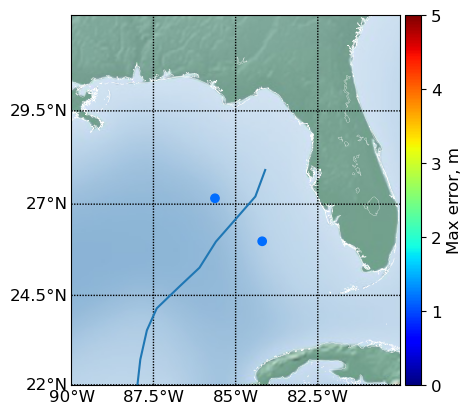

In [56]:
# Plot TC track, MicroSwift

fig = plt.figure()
map = Basemap(llcrnrlon=-90.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=32.,
      resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,32.,2.5)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-90,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x_ms, y_ms = map(lon_mean_ms_1,lat_mean_ms_1)
plt.plot(x, y)
plt.scatter(x_ms, y_ms, c= error_max_wvht_ms_1, marker='o', cmap='jet')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="Max error, m")
plt.clim(0,5)
plt.rcParams.update({'font.size': 12})
fig_name = path_out + 'max_error_ms_Hm0.png'
plt.savefig(fig_name)
plt.show()

6. SPOTTER buoy analysis

In [59]:
# Load, plot and analyze Spotter data

spotter_bulk_file = '/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30024D/waves_SPOT-30024D.csv'
spotter_data_1 = pd.read_csv(spotter_bulk_file)
lat_spotter_1 = spotter_data_1['latitude'].values
lon_spotter_1 = spotter_data_1['longitude'].values
Hm0_spotter_1 = spotter_data_1['significant_waveheight'].values

spotter_bulk_file = '/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30065D/waves_SPOT-30065D.csv'
spotter_data_2 = pd.read_csv(spotter_bulk_file)
lat_spotter_2 = spotter_data_2['latitude'].values
lon_spotter_2 = spotter_data_2['longitude'].values
Hm0_spotter_2 = spotter_data_2['significant_waveheight'].values

spotter_bulk_file = '/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30068D/waves_SPOT-30068D.csv'
spotter_data_3 = pd.read_csv(spotter_bulk_file)
lat_spotter_3 = spotter_data_3['latitude'].values
lon_spotter_3 = spotter_data_3['longitude'].values
Hm0_spotter_3 = spotter_data_3['significant_waveheight'].values

spotter_bulk_file = '/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30096D/waves_SPOT-30096D.csv'
spotter_data_4 = pd.read_csv(spotter_bulk_file)
lat_spotter_4 = spotter_data_4['latitude'].values
lon_spotter_4 = spotter_data_4['longitude'].values
Hm0_spotter_4 = spotter_data_4['significant_waveheight'].values

spotter_bulk_file = '/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30097D/waves_SPOT-30097D.csv'
spotter_data_5 = pd.read_csv(spotter_bulk_file)
lat_spotter_5 = spotter_data_5['latitude'].values
lon_spotter_5 = spotter_data_5['longitude'].values
Hm0_spotter_5 = spotter_data_5['significant_waveheight'].values

spotter_bulk_file = '/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30104D/waves_SPOT-30104D.csv'
spotter_data_6 = pd.read_csv(spotter_bulk_file)
lat_spotter_6 = spotter_data_6['latitude'].values
lon_spotter_6 = spotter_data_6['longitude'].values
Hm0_spotter_6 = spotter_data_6['significant_waveheight'].values

/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30024D/waves_SPOT-30024D.csv


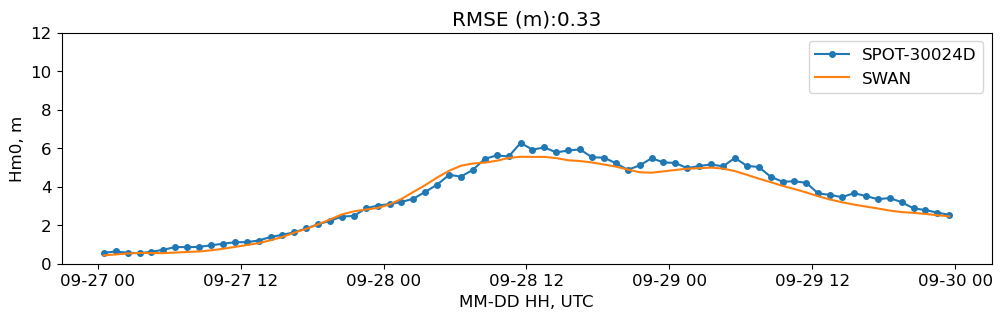

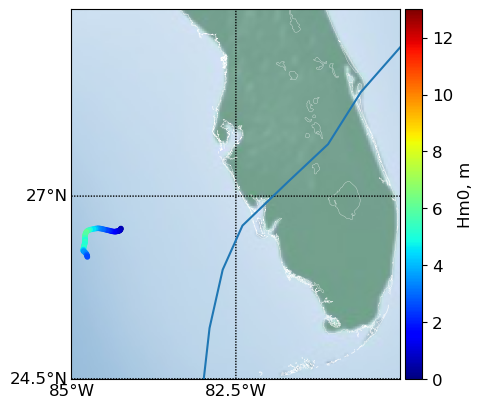

/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30065D/waves_SPOT-30065D.csv


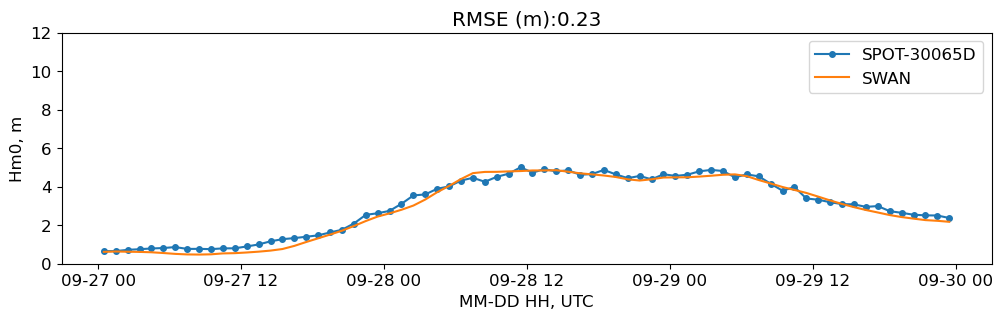

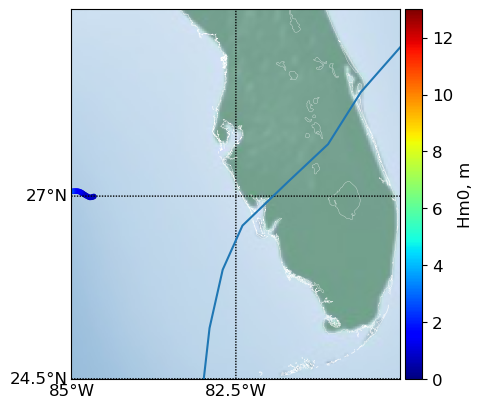

/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30068D/waves_SPOT-30068D.csv


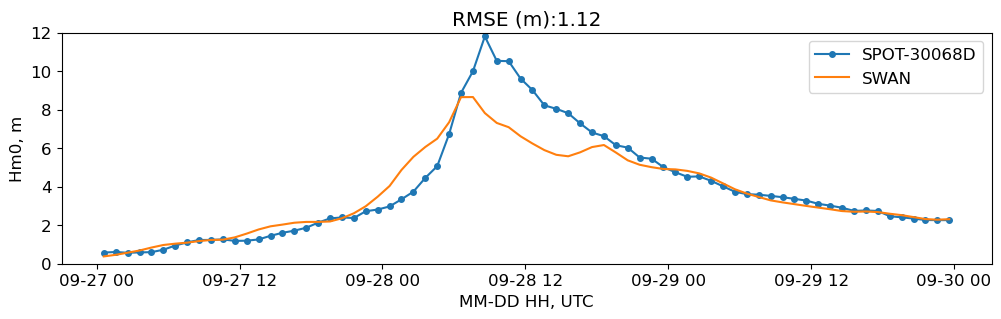

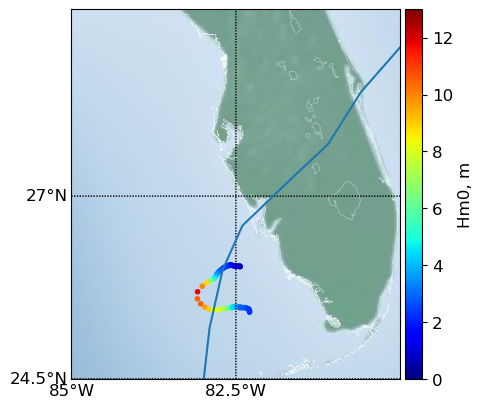

/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30096D/waves_SPOT-30096D.csv


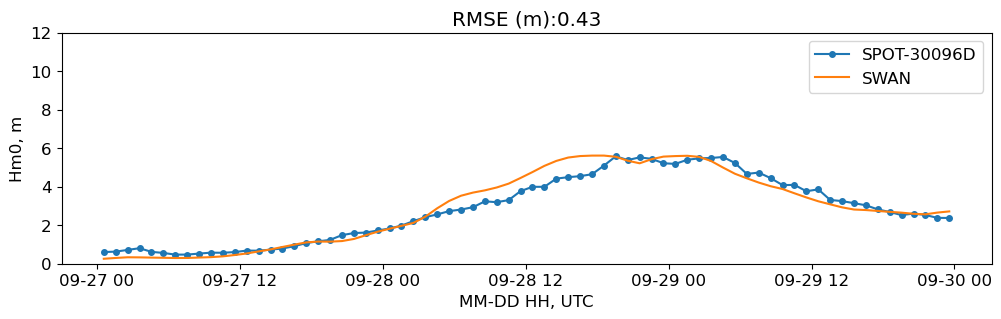

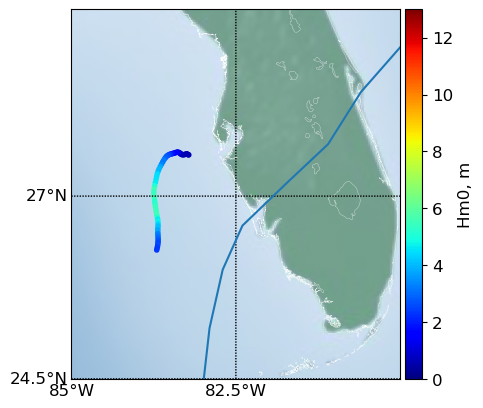

/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30097D/waves_SPOT-30097D.csv


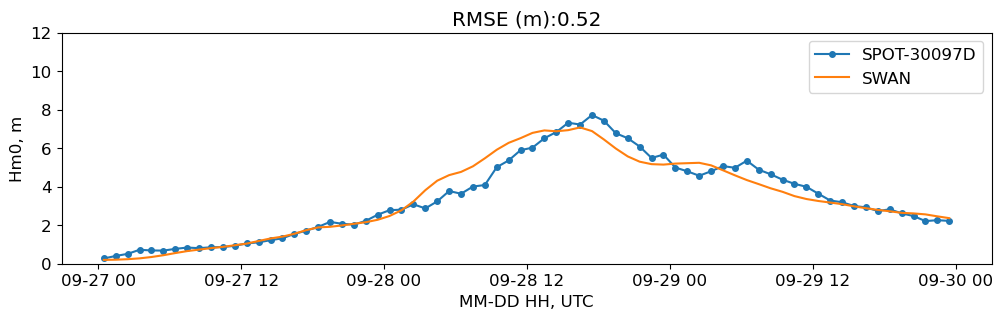

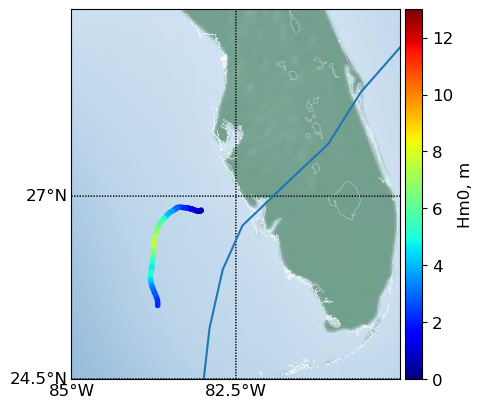

/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter/SPOT-30104D/waves_SPOT-30104D.csv


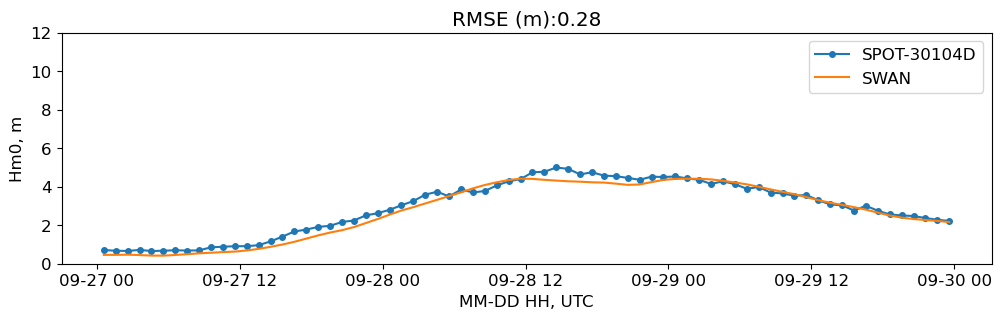

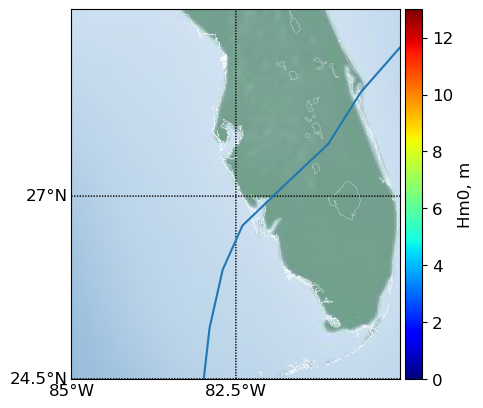

In [61]:
# Load, plot and analyze Spotter data

spotters = 'SPOT-30024D', 'SPOT-30065D', 'SPOT-30068D', 'SPOT-30096D', 'SPOT-30097D', 'SPOT-30104D'
path_spotters = '/mnt/d/NOPP/IAN_MEASUREMENTS/OffshoreBuoys/Spotter'

rmse_wvht_sp_1 = []
error_max_wvht_sp_1 = []
lon_mean_sp_1 = []
lat_mean_sp_1 = []

for spotter in spotters:
    spotter_bulk_file = path_spotters + '/' + spotter + '/waves_' + spotter + '.csv'
    print(spotter_bulk_file)
    spotter_data = pd.read_csv(spotter_bulk_file)
    lat_spotter = spotter_data['latitude'].values
    lon_spotter = spotter_data['longitude'].values
    Hm0_spotter = spotter_data['significant_waveheight'].values
    spotter_time = pd.to_datetime(spotter_data['timestamp'], infer_datetime_format = True).values
    
    count = 0
    count1 = 0
    Hwave_SWAN_sp_1 = Hm0_spotter*0
    lon_SWAN_sp_1 = Hm0_spotter*0
    lat_SWAN_sp_1 = Hm0_spotter*0
          
    for time in spotter_time:
     if spotter_time[count]<= time_end_model_1 and spotter_time[count] >= time_ini_model_1:
      tt_1 = ds_mod_1.Hwave.interp(ocean_time = spotter_time[count])  # intepolate in time
    
      # Find closest ROMS nodes to station locations
      dist = np.sqrt((lon_rho_1-lon_spotter[count])**2+(lat_rho_1-lat_spotter[count])**2)
      indy, indx = np.where(dist == np.amin(dist))
      lon_SWAN_sp_1[count] = lon_rho_1[indy,indx]
      lat_SWAN_sp_1[count] = lat_rho_1[indy,indx]
      Hwave_SWAN_sp_1[count] = tt_1[indy,indx].values
     else:
      Hwave_SWAN_sp_1[count] = np.nan
      lon_SWAN_sp_1[count] = np.nan
      lat_SWAN_sp_1[count] = np.nan
     count =count + 1 
        
    try:
       # Calculate Root Mean Square Error and max error
       differences = Hwave_SWAN_sp_1- Hm0_spotter
       differences_squared = differences ** 2 
       mean_of_differences_squared = np.nanmean(differences_squared,axis=0)
       rmse_1 = np.sqrt(mean_of_differences_squared)
       error_max_1 = np.nanmax(np.absolute(Hwave_SWAN_sp_1- Hm0_spotter))
    except:
       rmse_1 = np.nan
       error_max_1 = np.nan
        
    rmse_wvht_sp_1.append(rmse_1)
    error_max_wvht_sp_1.append(error_max_1)
    lon_mean_sp_1.append(np.mean(lon_spotter))
    lat_mean_sp_1.append(np.mean(lat_spotter))
    
    rmse_str_1 = str(rmse_1)[0:4]   
    max_err_1 = str(error_max_1)[0:4]
       
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(spotter_time,Hm0_spotter,marker='o',markersize=4)
    ax.plot(spotter_time,Hwave_SWAN_sp_1)
    ax.set_ylim([0, 12])
    plt.title('RMSE (m):' + rmse_str_1)
    plt.ylabel('Hm0, m')
    plt.xlabel('MM-DD HH, UTC')
    plt.legend([spotter,'SWAN'])
    fig_name = path_out + spotter +' _Hm0.png'
    plt.savefig(fig_name)
    

    # Plot TC track, locations of NDBC buoys, SIO buoys, MicroSwifts and Spotters 

    
    wvht_sp = Hm0_spotter
    fig = plt.figure()
    map = Basemap(llcrnrlon=-85.0,llcrnrlat=24.5,urcrnrlon=-80.,urcrnrlat=29.5,
             resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
    map.shadedrelief()
    map.drawcoastlines(color='white', linewidth=0.2)
    parallels = np.arange(24.5,29.5,2.5)
    # labels = [left,right,top,bottom]
    map.drawparallels(parallels,labels=[True,False,False,False])
    meridians = np.arange(-85,-80,2.5)
    map.drawmeridians(meridians,labels=[False,False,False,True])
    x, y = map(track_lon,track_lat)  # transform coordinates
    x4, y4 = map(lon_spotter,lat_spotter)
    plt.plot(x, y)
    plt.scatter(x4, y4, c= wvht_sp, marker='.', cmap='jet')
    plt.clim(0,13)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05) 
    plt.colorbar(cax=cax, label="Hm0, m")
    plt.clim(0,13)
    plt.rcParams.update({'font.size': 12})
    fig_name = path_out + spotter + '_ms_Hm0.png'
    plt.savefig(fig_name)
    plt.show()

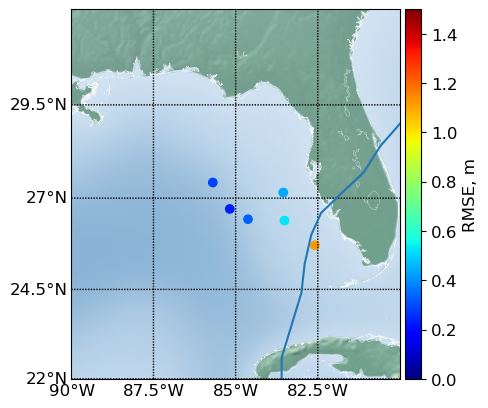

In [62]:
# Plot TC track, locations of NDBC buoys, SPOTTER buoys


fig = plt.figure()
map = Basemap(llcrnrlon=-90.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=32.,
      resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,32.,2.5)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-90,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x_sp, y_sp = map(lon_mean_sp_1,lat_mean_sp_1)
x, y = map(track_lon,track_lat)  # transform coordinates
plt.plot(x, y)
plt.scatter(x_sp, y_sp, c= rmse_wvht_sp_1, marker='o', cmap='jet')
plt.clim(0,1.5)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="RMSE, m")
plt.rcParams.update({'font.size': 12})
fig_name = path_out + 'rmse_sp_Hm0.png'
plt.savefig(fig_name)
plt.show()

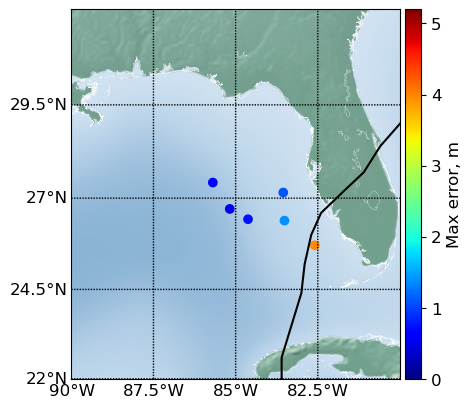

In [67]:
# Plot TC track, locations of NDBC buoys, SPOTTER buoys
x_sp, y_sp = map(lon_mean_sp_1,lat_mean_sp_1)

fig = plt.figure()
map = Basemap(llcrnrlon=-90.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=32.,
      resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,32.,2.5)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-90,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
plt.plot(x, y, color = 'black') ## TC track
plt.scatter(x_sp, y_sp, c= error_max_wvht_sp_1, marker='o', cmap='jet')
plt.clim(0,5.2)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="Max error, m")
plt.rcParams.update({'font.size': 12})
fig_name = path_out + 'max_error_sp_Hm0.png'
plt.savefig(fig_name)
plt.show()

8. Plot overal trends

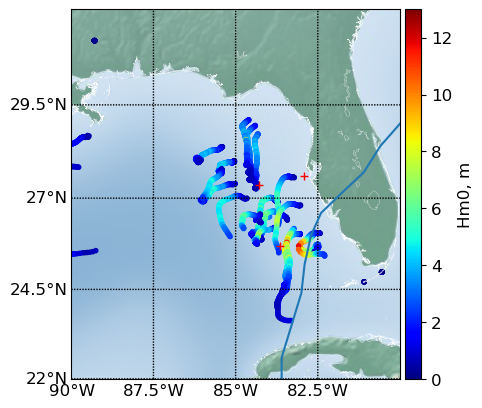

In [63]:
# Plot TC track, locations of NDBC buoys, SIO buoys, MicroSwifts and Spotters 

fig = plt.figure()
map = Basemap(llcrnrlon=-90.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=32.,
             resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,32.,2.5)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-90,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])

x_ndbc, y_ndbc = map(lon_ndbc_1,lat_ndbc_1)  # transform coordinates
llo = [x - 1.5 for x in lon_ndbc_1]
lla = [x + 0.3 for x in lat_ndbc_1]
x3, y3 = map(llo,lla)

x4, y4 = map(np.array(ds_sio.longitude.values),np.array(ds_sio.latitude.values))
wvht_sio = np.array(ds_sio.wvht.values)

x57, y57 = map(lon_57,lat_57)
x19, y19 = map(lon_19,lat_19)

xs_1, ys_1 = map(lon_spotter_1,lat_spotter_1)
xs_2, ys_2 = map(lon_spotter_2,lat_spotter_2)
xs_3, ys_3 = map(lon_spotter_3,lat_spotter_3)
xs_4, ys_4 = map(lon_spotter_4,lat_spotter_4)
xs_5, ys_5 = map(lon_spotter_5,lat_spotter_5)
xs_6, ys_6 = map(lon_spotter_6,lat_spotter_6)

x, y = map(track_lon,track_lat)  # transform coordinates
plt.plot(x, y)
plt.plot(x_ndbc[0], y_ndbc[0],  marker='+', color= 'red') ## ndbc 1
plt.plot(x_ndbc[1], y_ndbc[1],  marker='+', color= 'red') ## ndbc 2
plt.plot(x_ndbc[-1], y_ndbc[-1],  marker='+', color= 'red') ## ndbc 3
plt.scatter(x4, y4, c= wvht_sio, marker='.', cmap='jet')
plt.clim(0,13)
plt.scatter(x57, y57, c= whgt_57, marker='.', cmap='jet')
plt.clim(0,13)
plt.scatter(x19, y19, c= whgt_19, marker='.', cmap='jet')
plt.clim(0,13)
plt.scatter(xs_1, ys_1, c= Hm0_spotter_1, marker='.', cmap='jet')
plt.clim(0,13)
plt.scatter(xs_2, ys_2, c= Hm0_spotter_2, marker='.', cmap='jet')
plt.clim(0,13)
plt.scatter(xs_3, ys_3, c= Hm0_spotter_3, marker='.', cmap='jet')
plt.clim(0,13)
plt.scatter(xs_4, ys_4, c= Hm0_spotter_4, marker='.', cmap='jet')
plt.clim(0,13)
plt.scatter(xs_5, ys_5, c= Hm0_spotter_5, marker='.', cmap='jet')
plt.clim(0,13)
plt.scatter(xs_6, ys_6, c= Hm0_spotter_6, marker='.', cmap='jet')
plt.clim(0,13)
Hm0_spotter_6
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="Hm0, m")
plt.clim(0,13)
plt.rcParams.update({'font.size': 12})
fig_name =  path_out + 'Ian_track_ndbc_Hmo_sio_microS_spotter_drifters.png'
plt.savefig(fig_name)
plt.show()

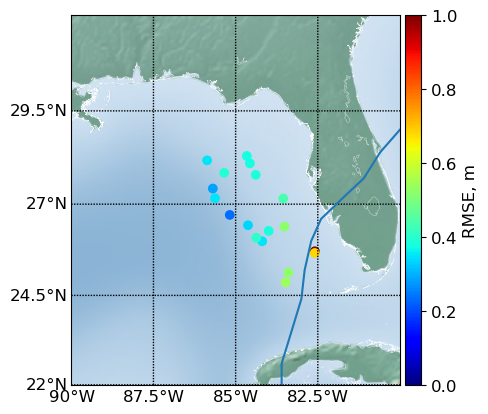

In [70]:
# RMSE: NDBC, SIO, MICROS, SPOTTERS and Plot TC track
fig = plt.figure()
map = Basemap(llcrnrlon=-90.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=32.,
      resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,32.,2.5)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-90,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x, y = map(track_lon,track_lat)  # transform coordinates
plt.plot(x, y)
#plt.scatter(x_ndbc, y_ndbc, c= rmse_whgt_ndbc_1, marker='o', cmap='jet')
#plt.clim(0,1.0)
plt.scatter(x_sp, y_sp, c= rmse_wvht_sp_1, marker='o', cmap='jet')
plt.clim(0,1.0)
plt.scatter(x_ms, y_ms, c= rmse_wvht_ms_1, marker='o', cmap='jet')
plt.clim(0,1.0)
plt.scatter(x_sio, y_sio, c= rmse_wvht_sio_1, marker='o', cmap='jet')
plt.clim(0,1.0)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="RMSE, m")
plt.clim(0,1.0)
plt.rcParams.update({'font.size': 12})
fig_name = path_out + 'rmse_global_Hm0.png'
plt.savefig(fig_name)
plt.show()

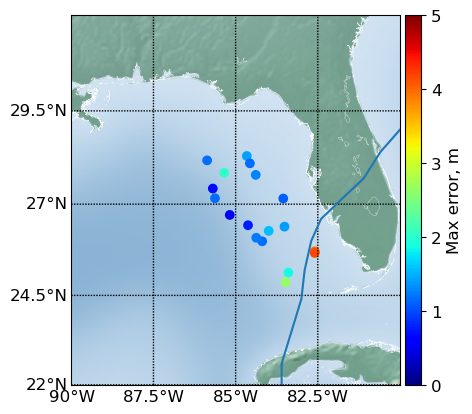

In [69]:
# RMSE: NDBC, SIO, MICROS, SPOTTERS and Plot TC track
fig = plt.figure()
map = Basemap(llcrnrlon=-90.0,llcrnrlat=22,urcrnrlon=-80.,urcrnrlat=32.,
      resolution='f', projection='merc', lat_0 = 27.5, lon_0 = -85.)
map.shadedrelief()
map.drawcoastlines(color='white', linewidth=0.2)
parallels = np.arange(22.,32.,2.5)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.arange(-90,-80,2.5)
map.drawmeridians(meridians,labels=[False,False,False,True])
x, y = map(track_lon,track_lat)  # transform coordinates
plt.plot(x, y)
#plt.scatter(x_ndbc, y_ndbc, c= max_error_whgt_ndbc_1, marker='o', cmap='jet')
#plt.clim(0,5)
plt.scatter(x_sp, y_sp, c= error_max_wvht_sp_1, marker='o', cmap='jet')
plt.clim(0,5)
plt.scatter(x_ms, y_ms, c= error_max_wvht_ms_1, marker='o', cmap='jet')
plt.clim(0,5)
plt.scatter(x_sio, y_sio, c= error_max_wvht_sio_1, marker='o', cmap='jet')
plt.clim(0,5)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(cax=cax, label="Max error, m")
plt.rcParams.update({'font.size': 12})
fig_name = path_out + 'error_max_global_Hm0.png'
plt.savefig(fig_name)
plt.show()